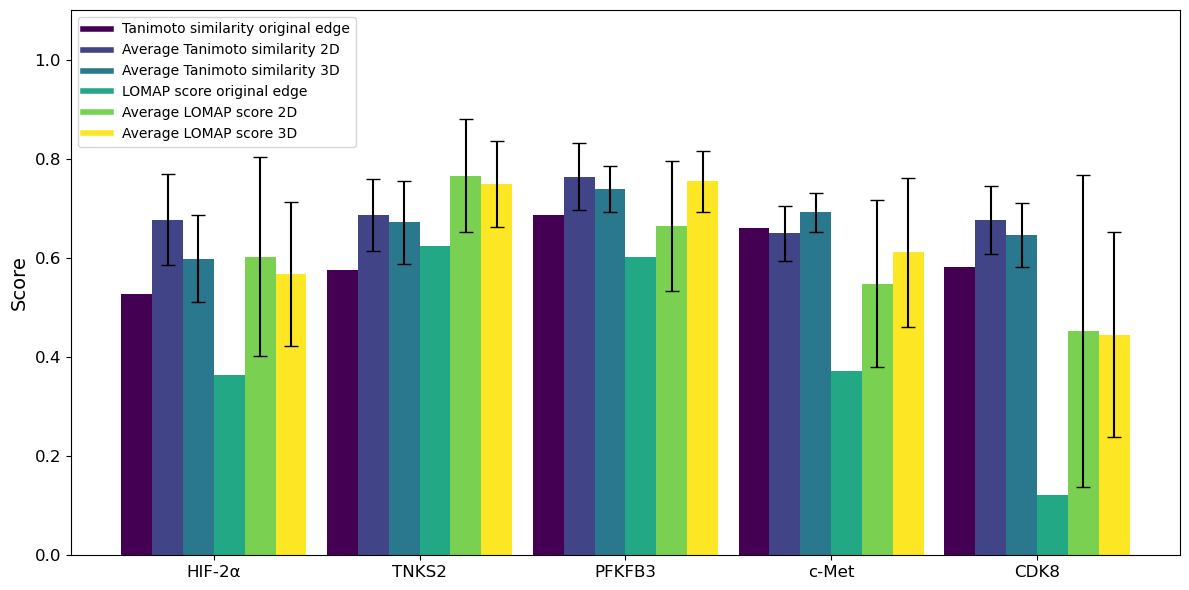

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm

# Define the directory containing the CSV files
csv_directory = "/path"

# Load all CSV file paths in the specified directory
csv_files = [os.path.join(csv_directory, file) for file in os.listdir(csv_directory) if file.endswith('.csv')]

# Initialize a dictionary to hold the data for plotting, indexed by tgt
data_dict = {}

# Loop through each CSV file, load the data, calculate statistics, and store the results
for csv_file in csv_files:
    # Load CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Extract the target for labeling
    tgt = df['tgt'].unique()[0]
    
    # Define columns of interest
    base_columns = ['Tanimoto_Liga_LigB', 'LOMAP_Liga_LigB']
    extra_columns = ['Average_Tanimoto', 'Average_LOMAP']
    sem_columns = ['Tanimoto_SEM', 'LOMAP_SEM']
    all_columns = base_columns + extra_columns + sem_columns
    
    stats_dict = {}
    for col in base_columns:
        # Calculate statistics for base columns (common to both 2D and 3D)
        mean = df[col].mean()
        stats_dict[col] = mean
    
    for scoring_method in ['2D', '3D']:
        # Filter DataFrame based on ScoringMethod
        filtered_df = df[df['ScoringMethod'] == scoring_method]

        # Check if the filtered DataFrame is empty
        if filtered_df.empty:
            continue

        # Stack the values from the Intermediate columns and calculate SEM for each row
        tanimoto_values = filtered_df[['Tanimoto_Liga_Intermediate', 'Tanimoto_LigB_Intermediate']].stack()
        tanimoto_sems = tanimoto_values.groupby(level=0).sem()
        lomap_values = filtered_df[['LOMAP_Liga_Intermediate', 'LOMAP_LigB_Intermediate']].stack()
        lomap_sems = lomap_values.groupby(level=0).sem()

        # Average the individual SEM values
        tanimoto_sem_avg = tanimoto_sems.mean()
        lomap_sem_avg = lomap_sems.mean()

        # Calculate statistics for Average_Tanimoto and Average_LOMAP separately for 2D and 3D
        for col, sem in zip(extra_columns, [tanimoto_sem_avg, lomap_sem_avg]):
            mean = filtered_df[col].mean()
            column_name = f"{col}_{scoring_method}"  # Append 2D or 3D to the column name
            stats_dict[column_name] = (mean, sem)
    
    # Store the results in the data dictionary
    if tgt not in data_dict:
        data_dict[tgt] = stats_dict
    else:
        data_dict[tgt].update(stats_dict)

# Define a colormap and create a color list
colors = cm.viridis(np.linspace(0, 1, 6))

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Define bar width
bar_width = 0.15

# Calculate the indices for the bar positions
indices = np.arange(len(data_dict))


# Loop over the data_dict and plot bars
for i, (tgt, stats_dict) in enumerate(data_dict.items()):
    # Plot Tanimoto_Liga_LigB bar
    ax.bar(indices[i], stats_dict['Tanimoto_Liga_LigB'], width=bar_width, label=f"{tgt}_Tanimoto_Liga_LigB", color=colors[0])
    
    # Plot Average_Tanimoto_2D bar with SEM
    if 'Average_Tanimoto_2D' in stats_dict:
        mean, sem = stats_dict['Average_Tanimoto_2D']
        ax.bar(indices[i] + bar_width, mean, width=bar_width, label=f"{tgt}_Average_Tanimoto_2D", yerr=sem, color=colors[1], capsize=5)
    
    # Plot Average_Tanimoto_3D bar with SEM
    if 'Average_Tanimoto_3D' in stats_dict:
        mean, sem = stats_dict['Average_Tanimoto_3D']
        ax.bar(indices[i] + 2 * bar_width, mean, width=bar_width, label=f"{tgt}_Average_Tanimot,o_3D", yerr=sem, color=colors[2], capsize=5)
    
    # Plot LOMAP_Liga_LigB bar
    ax.bar(indices[i] + 3 * bar_width, stats_dict['LOMAP_Liga_LigB'], width=bar_width, label=f"{tgt}_LOMAP_Liga_LigB", color=colors[3])
    
    # Plot Average_LOMAP_2D bar with SEM
    if 'Average_LOMAP_2D' in stats_dict:
        mean, sem = stats_dict['Average_LOMAP_2D']
        ax.bar(indices[i] + 4 * bar_width, mean, width=bar_width, label=f"{tgt}_Average_LOMAP_2D", yerr=sem, color=colors[4], capsize=5)
    
    # Plot Average_LOMAP_3D bar with SEM
    if 'Average_LOMAP_3D' in stats_dict:
        mean, sem = stats_dict['Average_LOMAP_3D']
        ax.bar(indices[i] + 5 * bar_width, mean, width=bar_width, label=f"{tgt}_Average_LOMAP_3D", yerr=sem, color=colors[5], capsize=5)


# Set the x-ticks, labels, title, legend, etc.
ax.set_xticks(indices + bar_width * 2.5)
ax.set_xticklabels([tgt for tgt in data_dict.keys()])
ax.set_ylabel('Score', fontsize=14)
#ax.set_xlabel('Receptor')

ax.set_ylim(0,1.1)
ax.tick_params(axis='both', labelsize=12)

receptor_labels = {
    'cdk8': 'CDK8',
    'hif2a': 'HIF-2α',
    'tnks2': 'TNKS2',
    'pfkfb3': 'PFKFB3',
    'cmet': 'c-Met',
    # Add more mappings as needed
}

ax.set_xticklabels([receptor_labels.get(tgt, tgt) for tgt in data_dict.keys()])

# Create a custom legend to represent columns
custom_lines = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
custom_labels = ['Tanimoto similarity original edge', 'Average Tanimoto similarity 2D', 'Average Tanimoto similarity 3D', 'LOMAP score original edge', 'Average LOMAP score 2D', 'Average LOMAP score 3D']
ax.legend(custom_lines, custom_labels, loc='upper left', 
          #bbox_to_anchor=(1, 1)
         )

# Show the plot
plt.tight_layout()
plt.show()

fig.savefig("figure3.svg", format='svg', dpi=1200)
